# TED Talk Analysis

In this notebook we perform the Data Understanding of our dataset which includes data cleaning, feature engineering, showing correlations and showing useful plots such as bar charts, scatter plots, and box plots. 

## Importing libraries 

In [180]:
%matplotlib inline
import numpy as np
import pandas as pd 
import scipy as sp
import sklearn as sk # data mining tools
import matplotlib.pylab as plt # plotting
import seaborn as sns # advanced plotting
import ast
import collections
import re 
import six
from sklearn.preprocessing import MinMaxScaler
pd.options.display.max_colwidth = 100
pd.options.mode.chained_assignment = None

## Reading main dataset 

In [2]:
df = pd.read_csv('ted_main.csv')

## Data Cleaning

### finding missing values

In [3]:
df.isnull().sum()

comments              0
description           0
duration              0
event                 0
film_date             0
languages             0
main_speaker          0
name                  0
num_speaker           0
published_date        0
ratings               0
related_talks         0
speaker_occupation    6
tags                  0
title                 0
url                   0
views                 0
dtype: int64

Only speaker_occupation has (apparent) missing values. We can fill them by the mode.

In [4]:
df['speaker_occupation'].fillna(df['speaker_occupation'].mode()[0], inplace = True)
###Since only 6 of them are missing, we can try to look for 
###the information by ourselves and add them to the data we have.
#df.replace({'speaker_occupation': {na: 'Water Data/Risk Wrangler'}})

### Distribution of the variables

This is a function for showing distribution of different columns in dataset.

In [12]:
def show_dist(dataset, column):
    dataset[column].plot.kde()
    plt.title("Distribution of " + column)
    plt.xlabel(column)
    plt.show()

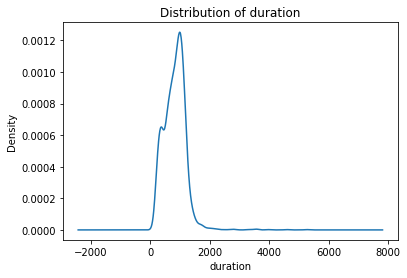

In [13]:
show_dist(df, 'duration')

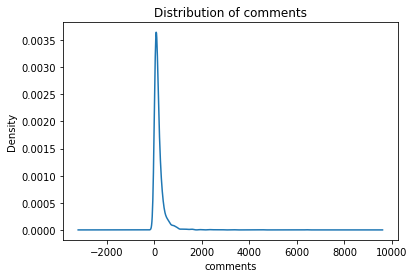

In [14]:
show_dist(df, 'comments')

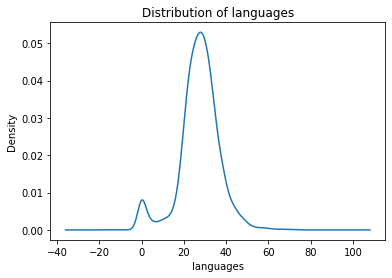

In [15]:
show_dist(df, 'languages')

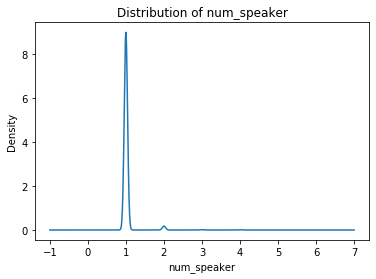

In [16]:
show_dist(df, 'num_speaker')

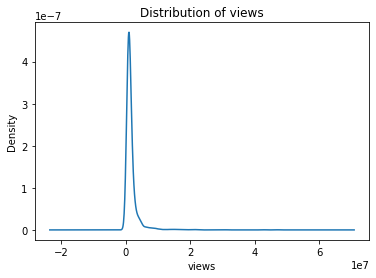

In [17]:
show_dist(df, 'views')

## Feature Engineering

### Popularity Factor

In this part the popularity factor is created. It is calculated as mean of min_max normalized value of number of comments, number of views and sum of ratings. 

In [34]:
df['comm_sc'] = ( df['comments'] - df['comments'].min() ) / ( df['comments'].max() - df['comments'].min() )
df['views_sc'] = ( df['views'] - df['views'].min() ) / ( df['views'].max() - df['views'].min() )
df['ratings'] = df['ratings'].apply(lambda x: ast.literal_eval(x))
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x))
df['ratings_count'] = 0

for i in range(2550):
    cnt = 0
    for rev in range(0, 14):
        cnt = cnt + df['ratings'][i][rev].get('count')
    df.loc[(i, 'ratings_count')] = cnt
    
df['ratings_nbr_sc'] = ( df['ratings_count'] - df['ratings_count'].min() ) / ( df['ratings_count'].max() - df['ratings_count'].min() )
df['popularity'] = ( df['views_sc'] + df['comm_sc'] + df['ratings_nbr_sc']) / 3
df.drop(['comm_sc','views_sc', 'ratings_nbr_sc'], axis=1, inplace = True)

### Funny Factor

In this part the funny factor is created. It is calculated as mean of min_max normalized value of number of funny in ratings and number of word "laughter" in transcripts.

In [36]:
df['funny_count'] = 0
for i in range(0,2550):
    funny_rating = 0
    for j in range(0,14):
        funny_id = df['ratings'][i][j].get('id')
        if funny_id == 7:
            funny_rating = funny_rating + df['ratings'][i][j].get('count')      
    df.loc[(i, 'funny_count')] = funny_rating
df_trans = pd.read_csv('transcripts.csv')
df_trans['laughter'] = 0
# Drop duplicates 
df_trans.drop_duplicates(keep = False,inplace = True)
# re_assign index after droping dupliacte rows 
df_trans.index = range(0,len(df_trans))

#iterate in each row and sum frequency of the word 'Laughter'
#append the value to 'laughter' col

word = 'Laughter'
for i in range(0,2461):
    count = 0
    input_tedtalk = df_trans['transcript'][i] 
    count = count + sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), input_tedtalk))
    df_trans.loc[(i,'laughter')] = count

#  frequency of funny 
df['Scaled_fcount']  = ((df['funny_count'] - df['funny_count'].min()) / (df['funny_count'].max() - df['funny_count'].min()))
# frequency of laughter 
df_trans['Scaled_laugh']  = (df_trans['laughter'] - df_trans['laughter'].min()) / (df_trans['laughter'].max() - df_trans['laughter'].min())
# Merge the two datafarmes on column = url (inner join) and return a DF
df = pd.merge(df,df_trans, on = 'url', how='outer')
df.update(df[['Scaled_fcount','Scaled_laugh','funny_count','laughter']].fillna(0))
df['funny_factor'] = (df['Scaled_fcount'] + df['Scaled_laugh'])/2
df.drop(['Scaled_fcount','Scaled_laugh', 'funny_count', 'laughter'], axis=1, inplace = True)

### Year

Here another feature is created. published_date which is seconds is converted into timestamp and then year is extracted.

In [56]:
df['year'] = df['published_date'].apply(lambda x: pd.to_datetime(x, unit='s').year)

## Histogram and Bar Charts

This is a function for showing histogram of frequency of a numerical feature.

In [39]:
def histogram(data, feature, min_val, max_val):
    feature_ = feature
    plt.figure(figsize=(7,5))
    plt.hist(data[feature_][(data[feature_] > min_val) & (data[feature_] < max_val)], bins=50)
    plt.title("Histogram of " + feature + " between " + str(min_val) + " and " + str(max_val))
    plt.ylabel('Frequency')
    plt.xlabel(feature)

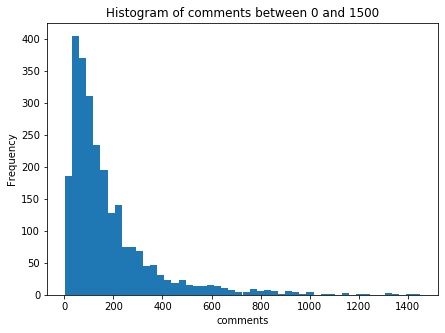

In [40]:
histogram(df, 'comments', 0, 1500)

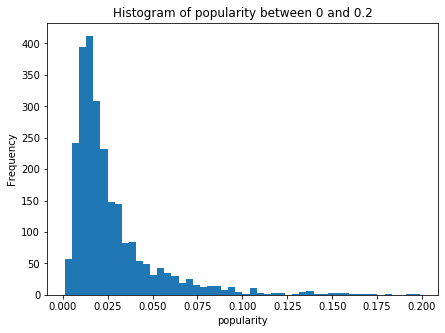

In [41]:
histogram(df, 'popularity', 0, 0.2)

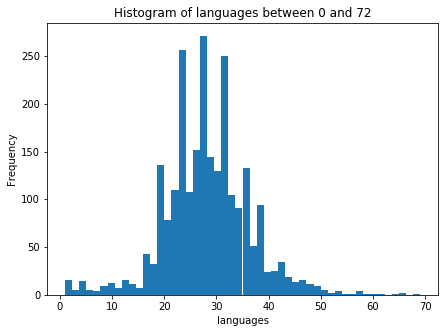

In [43]:
histogram(df, 'languages', 0, df.languages.max())

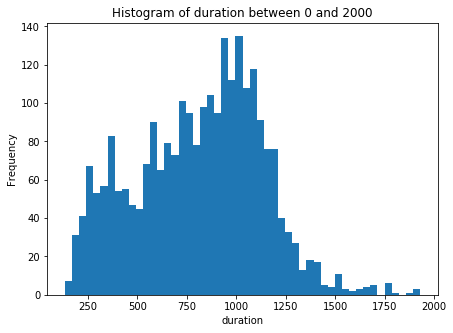

In [44]:
histogram(df, 'duration', 0, 2000)

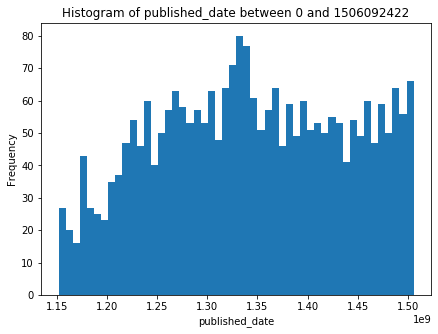

In [46]:
histogram(df, 'published_date', 0, df['published_date'].max())

This is a function for showing highest number of values based on a categorical feature

In [47]:
def show_tops(dataset, feature, limit):
    value_counts = dataset[feature].value_counts()
    #events[0:20].plot(kind='bar')
    df = value_counts.rename_axis(feature).reset_index(name='count')
    df.sort_values(by=['count'], ascending=False)[0:limit].plot(kind='bar',x = feature, figsize=(0.8*limit,5),rot=0, grid=True)
    plt.title("Top " + str(limit) + " " + feature + "s")
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.xticks(rotation='vertical')
    plt.legend([])
    plt.show()

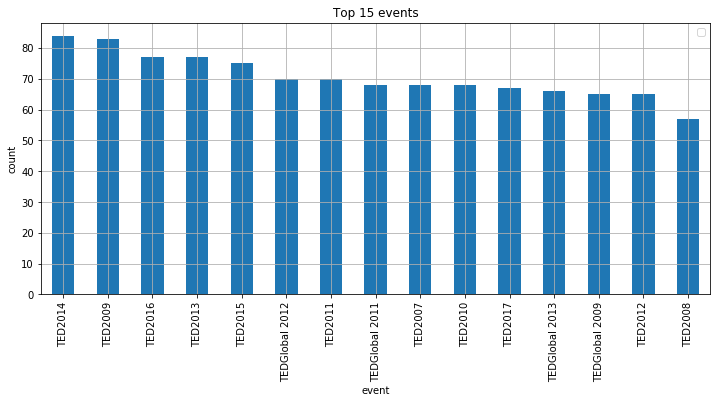

In [48]:
show_tops(df, 'event', 15)

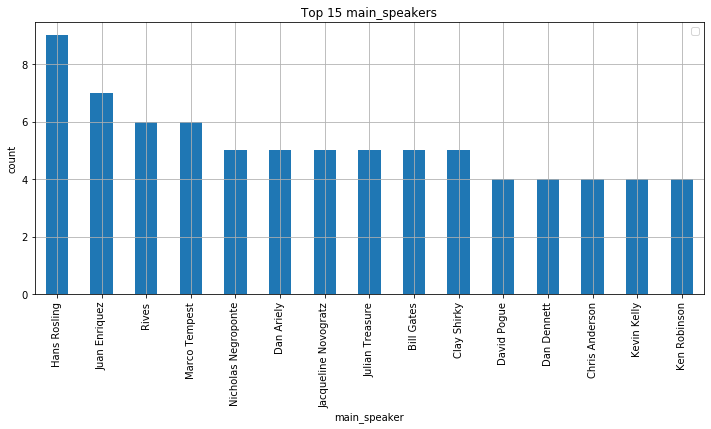

In [49]:
show_tops(df, 'main_speaker', 15)

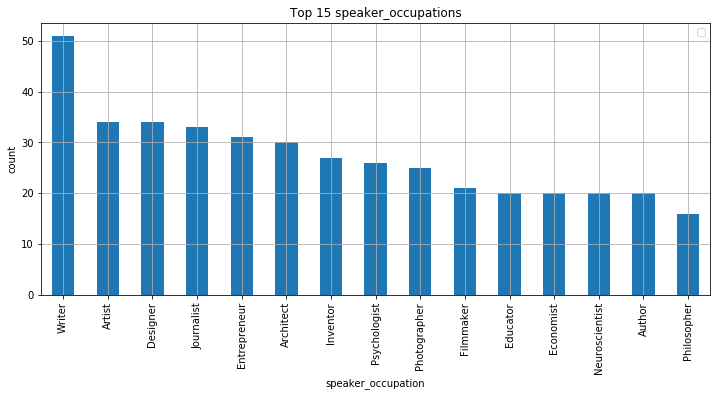

In [50]:
show_tops(df, 'speaker_occupation', 15)

Here another dataset is created consisting frequency of different tags used in talks.

In [53]:
tags = []
for i in range(2550):
    for j in range(len(df['tags'][i])):
        tags.append(df['tags'][i][j])
counter=collections.Counter(tags)
tags_df = pd.Series(counter,index=counter.keys()).rename_axis('tags').reset_index(name='count')

This is a function for showing bar chart based on values of two features.

In [54]:
def show_bar(df, categorical_feature, numerical_feature, limit):
    #fig, ax = plt.subplots()
    df.sort_values(by=[numerical_feature], ascending=False)[0:limit].plot(kind='bar',x = categorical_feature, figsize=(0.8*limit,5),rot=0, grid=True)
    plt.title("Top " + str(limit) + " " + categorical_feature + " by " + numerical_feature)
    plt.xlabel(categorical_feature)
    plt.ylabel(numerical_feature)
    plt.xticks(rotation='vertical')
    plt.legend([])
    plt.show()

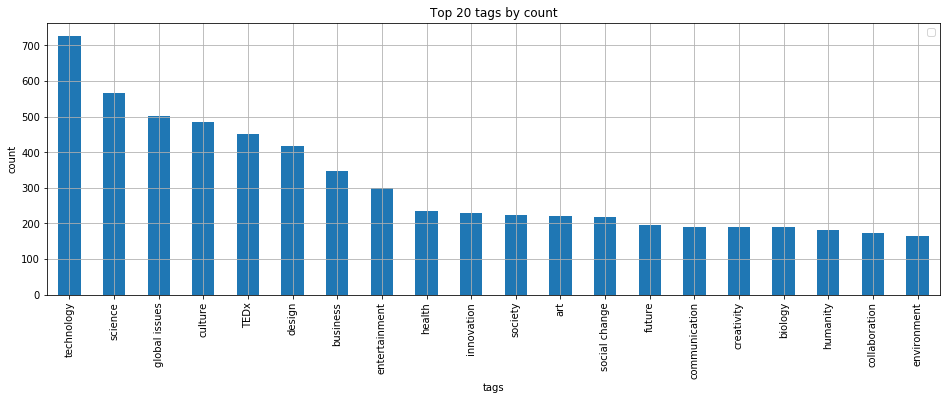

In [57]:
show_bar(tags_df, 'tags', 'count', 20)

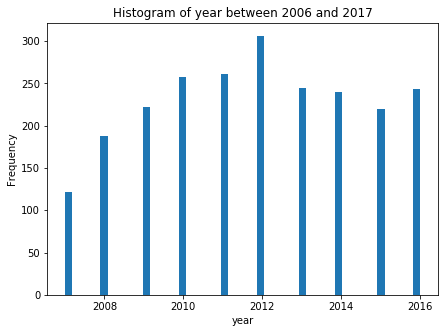

In [58]:
histogram(df, 'year', df['year'].min(), df['year'].max())

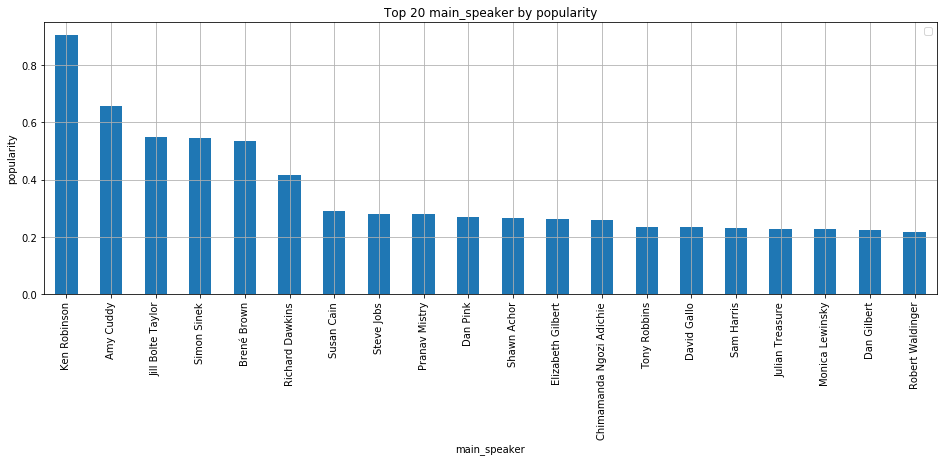

In [59]:
show_bar(df[['main_speaker','popularity']], 'main_speaker', 'popularity', 20)

This is a function for showing bar chart based on aggregation of one feature.

In [68]:
def show_bar_aggregate(dataset, feature1, feature2, aggregation, limit):
    df = pd.DataFrame([])
    if aggregation == 'mean':
        df = dataset.groupby([feature1])[feature2].mean().rename_axis(feature1).reset_index(name=aggregation)
    elif aggregation == 'min':
        df = dataset.groupby([feature1])[feature2].min().rename_axis(feature1).reset_index(name=aggregation)
    elif aggregation == 'max':
        df = dataset.groupby([feature1])[feature2].max().rename_axis(feature1).reset_index(name=aggregation)
    df.sort_values(by=[aggregation], ascending=False)[0:limit].plot(kind='bar',x = feature1, figsize=(0.8*limit,5),rot=0, grid=True)
    plt.title("Top " + str(limit) + " " + feature1 + " by " + aggregation + " of " + feature2)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.xticks(rotation='vertical')
    plt.legend([])
    plt.show()

This is a function for showing two bar charts next to eachother for comparison. 

In [65]:
def show_bar_agg_two_groups(dataset, feature1, feature2, feature3, aggregation, limit):
    df = pd.DataFrame([])
    if aggregation == 'mean':
        df = dataset.groupby([feature1])[feature2, feature3].mean().rename_axis(feature1).reset_index(feature1)
    elif aggregation == 'min':
        df = dataset.groupby([feature1])[feature2, feature3].min().rename_axis(feature1).reset_index(feature1)
    elif aggregation == 'max':
        df = dataset.groupby([feature1])[feature2, feature3].max().rename_axis(feature1).reset_index(feature1)
    df.sort_values(by=[feature2], ascending=False)[0:limit].plot(kind='bar',x = feature1,y=[feature2, feature3], figsize=(0.8*limit,5),rot=0, grid=True)
    plt.title("Top " + str(limit) + " " + feature1 + " by " + aggregation + " of " + feature2 + " and " + feature3)
    plt.xlabel(feature1)
    plt.ylabel(feature2 + " and " + feature3)
    plt.xticks(rotation='vertical')
    #plt.legend([])
    plt.show()

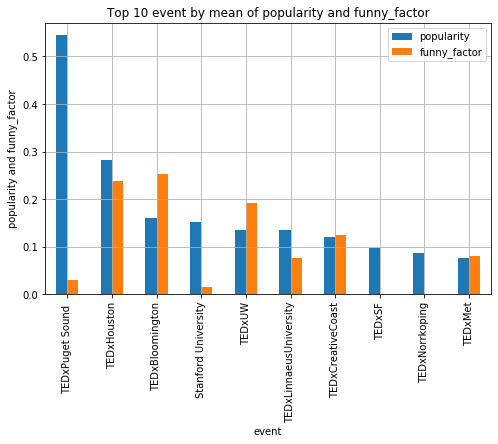

In [66]:
show_bar_agg_two_groups(df, 'event', 'popularity', 'funny_factor', 'mean', 10)

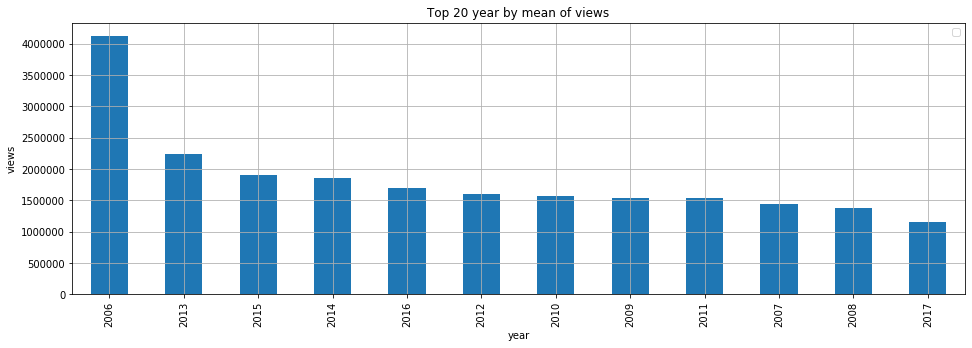

In [70]:
show_bar_aggregate(df, 'year', 'views', 'mean', 20)

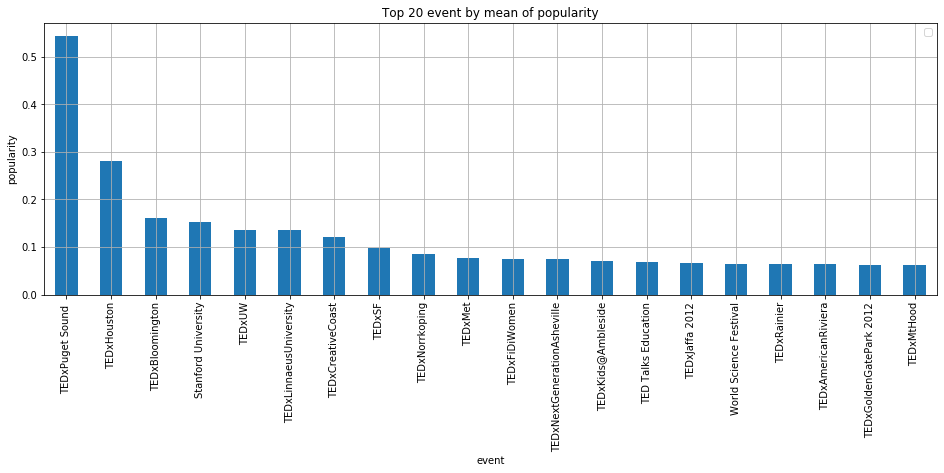

In [71]:
show_bar_aggregate(df, 'event', 'popularity', 'mean', 20)

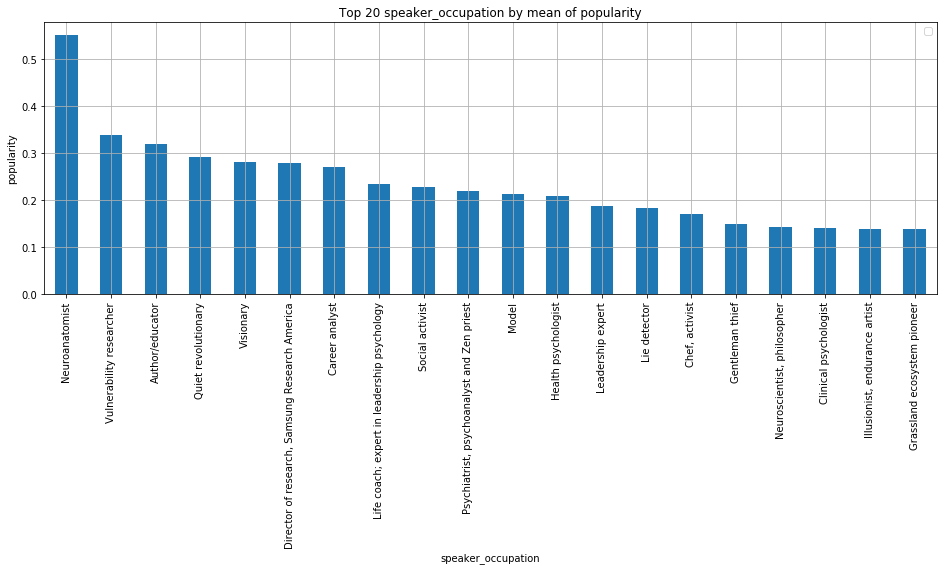

In [72]:
show_bar_aggregate(df, 'speaker_occupation', 'popularity', 'mean', 20)

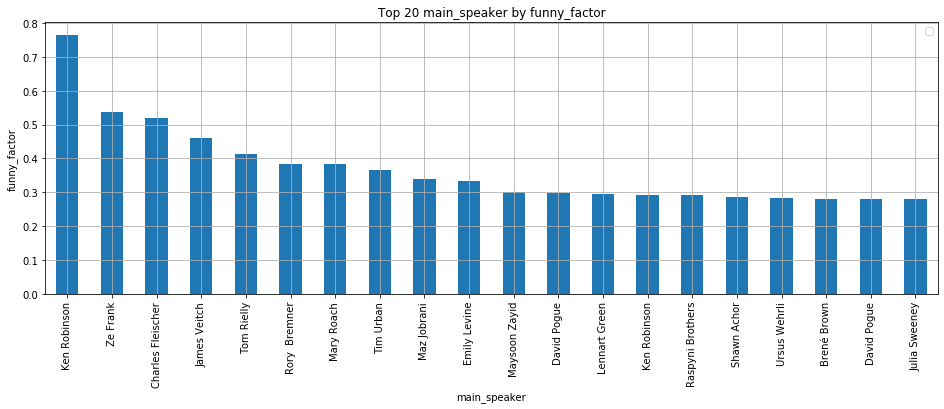

In [73]:
show_bar(df[['main_speaker','funny_factor']], 'main_speaker', 'funny_factor', 20)

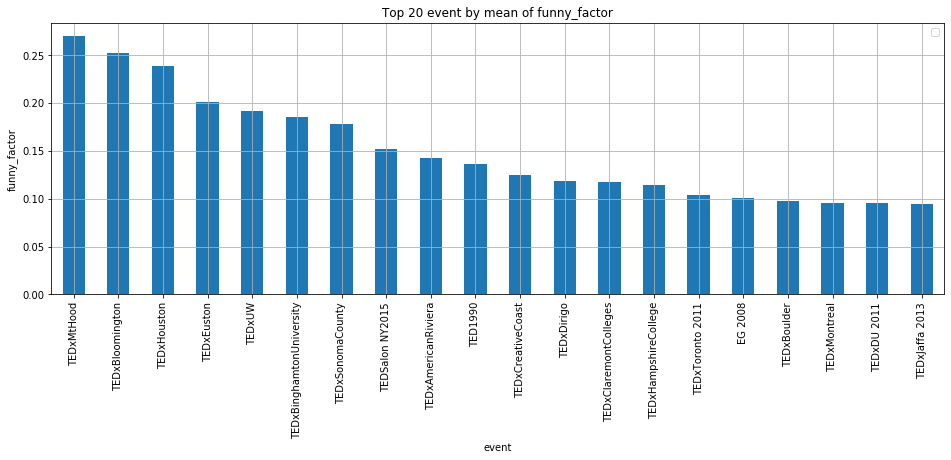

In [74]:
show_bar_aggregate(df, 'event', 'funny_factor', 'mean', 20)

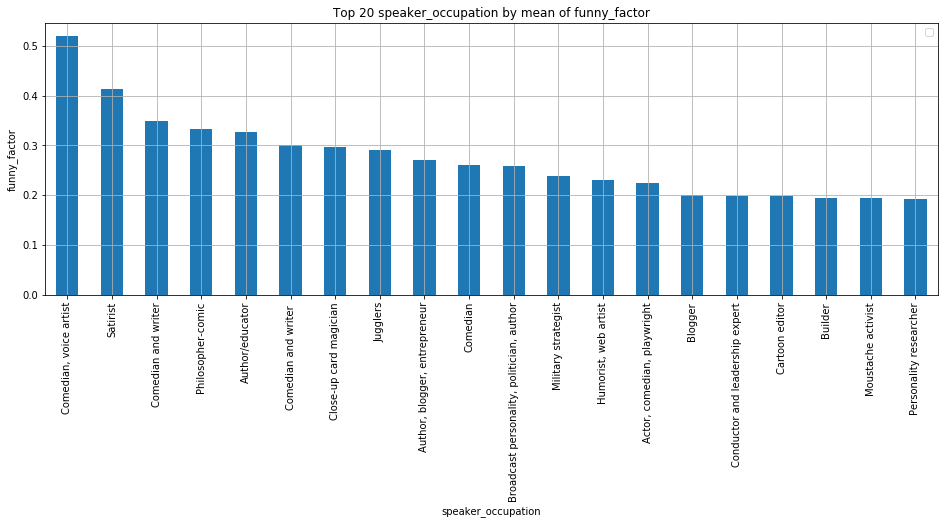

In [75]:
show_bar_aggregate(df, 'speaker_occupation', 'funny_factor', 'mean', 20)

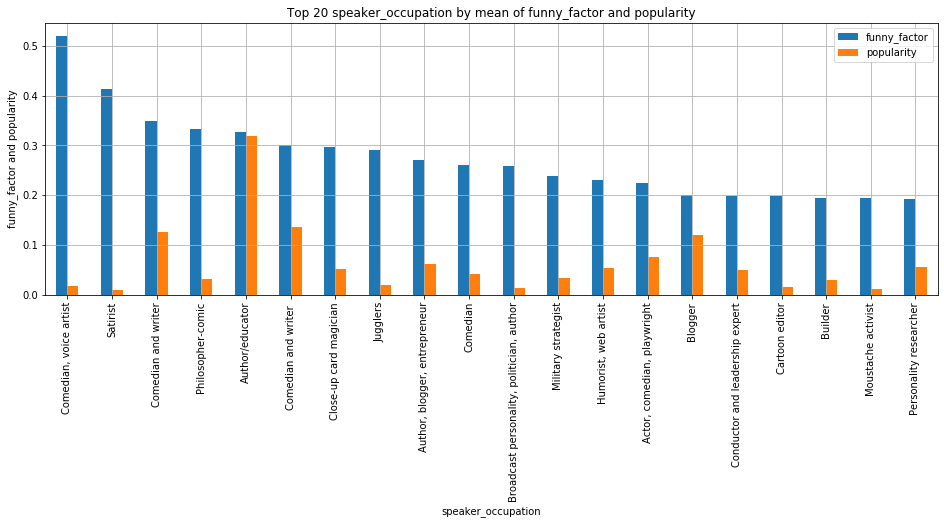

In [76]:
show_bar_agg_two_groups(df, 'speaker_occupation', 'funny_factor','popularity', 'mean', 20)

## Scatter Plots

In [132]:
#creating the generic function
def scatter (dataset, col1,col2):
    plt.plot( dataset[col1], dataset[col2], linestyle='', marker='o', markersize=0.7)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title((col1 +' VS '+ col2), loc='center')

(0, 2500000)

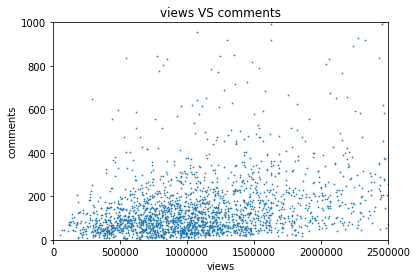

In [134]:
scatter(df, 'views','comments')
plt.ylim(0, 1000)
plt.xlim(0, 2500000)

(0, 2500000)

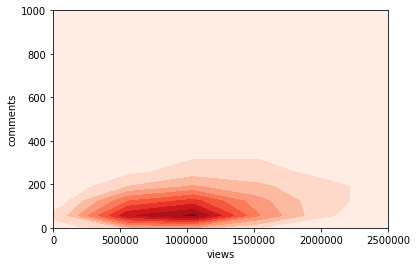

In [136]:
sns.kdeplot(df['views'], df['comments'], cmap="Reds", shade=True)
plt.ylim(0, 1000)
plt.xlim(0, 2500000)

(0, 3000000)

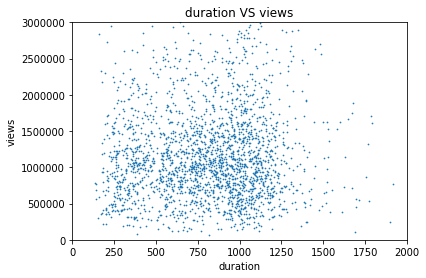

In [137]:
scatter(df, 'duration','views')
plt.xlim(0, 2000)
plt.ylim(0, 3000000)

(0, 2000)

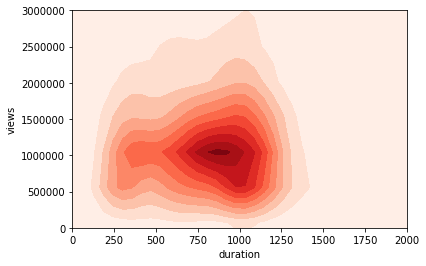

In [138]:
sns.kdeplot(df['duration'], df['views'], cmap="Reds", shade=True)
plt.ylim(0, 3000000)
plt.xlim(0, 2000)

(0, 1500)

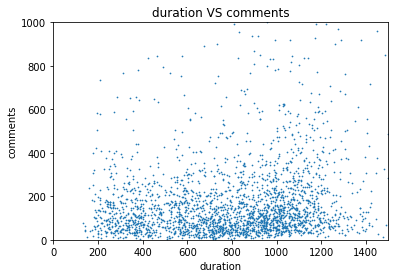

In [139]:
scatter(df, 'duration','comments')
plt.ylim(0, 1000)
plt.xlim(0, 1500)

(0, 1500)

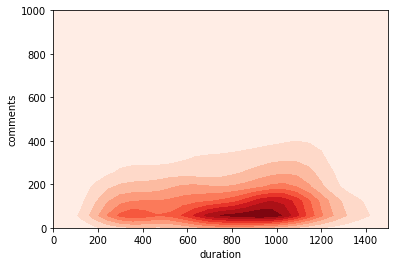

In [140]:
sns.kdeplot(df['duration'], df['comments'], cmap="Reds", shade=True)
plt.ylim(0, 1000)
plt.xlim(0, 1500)

(1000000000, 1600000000)

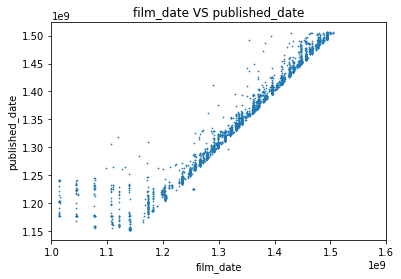

In [141]:
scatter(df, 'film_date','published_date')
plt.xlim(1000000000,1600000000)

(0, 0.2)

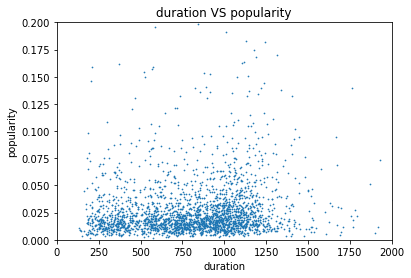

In [142]:
scatter(df, 'duration','popularity')
plt.xlim(0,2000)
plt.ylim(0,0.2)

(0, 0.08)

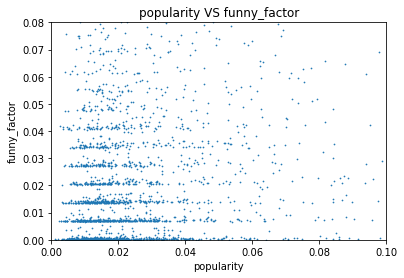

In [143]:
scatter(df, 'popularity','funny_factor')
plt.xlim(0,0.1)
plt.ylim(0,0.08)

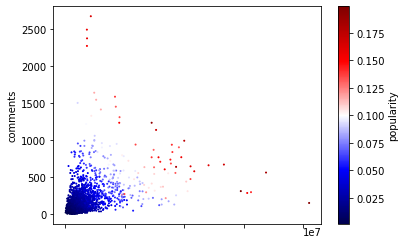

In [153]:
ax = df[df.popularity < 0.2].plot.scatter(x='views', y='comments', c='popularity', colormap='seismic',s=1)
plt.show()
#plt.ylim(0, 1000)
#plt.xlim(0, 2500000)

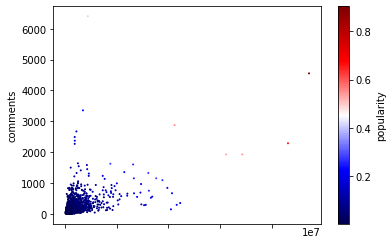

In [154]:
ax = df.plot.scatter(x='views', y='comments', c='popularity', colormap='seismic',s=1)
plt.xlabel('xlabel')
ax.set_xlabel("x label")
plt.show()
#plt.ylim(0, 1000)
#plt.xlim(0, 2500000)

## Correlation Analysis
#### Compute Pearson correlation coefficent for evey numeric feature  

In [158]:
# create new data frame with numeric features and perfom Min_Max scaling
# merge popularity, funny_factor and published date with the scaled features
df_features = df[['comments','duration','languages', 'num_speaker','views','ratings_count']]
sclar = MinMaxScaler()
df_scaled = sclar.fit_transform(df_features)
df_corr = pd.DataFrame(df_scaled, columns = ['comments','duration','languages', 'num_speaker','views','ratings_count'])
df_corr['popularity'] = df['popularity']
df_corr['funny_factor'] = df['funny_factor']
df_corr['published_date'] = df['published_date']

In [159]:
# Convert a timestamp 'published_date' value into date object then convert the value to the corresponding weekday
from datetime import datetime
import calendar 
df_corr['Published_day'] = df_corr['published_date'].apply(lambda x: datetime.fromtimestamp(x).strftime('%m/%d/%Y'))
df_corr['Pweek_day']= (pd.to_datetime(df_corr['Published_day'])).apply(lambda d: calendar.day_name[d.weekday()])

In [160]:
dfcorr_copy = df_corr.copy()
dfcorr_copy.drop(['published_date','Published_day', 'Pweek_day'], axis = 1, inplace = True)

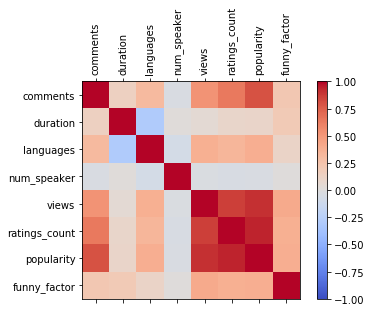

In [161]:
# Compute Pearson correlation for each pair of features
# pair wise correlation matrix, the darker the color, higher the correlation, 
# dark brown postively indcate +ve corrlation and dark blue -ve correlation 
correlation = dfcorr_copy.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(dfcorr_copy.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(dfcorr_copy.columns)
ax.set_yticklabels(dfcorr_copy.columns)
plt.show()

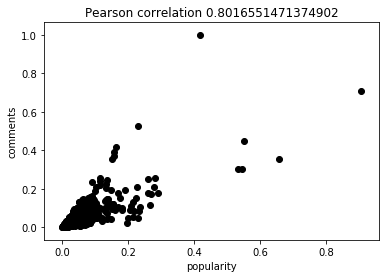

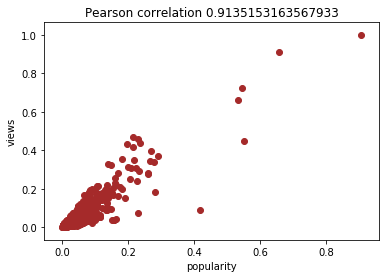

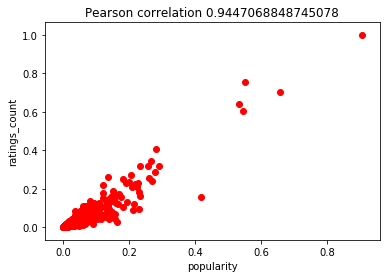

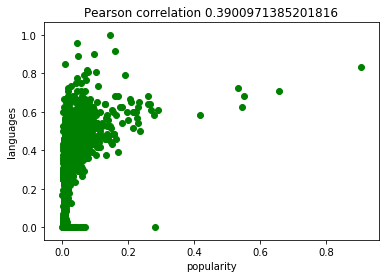

In [162]:
# function to plot a scatter plot for column in X , on x-axis with column Y , on y=axis
import random
X = ['popularity']
Y = ['comments','views','ratings_count','languages']
colors = ['red','black','blue','green','yellow','brown']
#fig, axs = plt.subplots(4, 3,figsize=(20,30))
def scatter_plotter(X,Y):
    for x in X:
        for y in Y:
            if x == y:
                pass
            else:
                pcor = 0 
                #ax1= fig.add_subplot(2,2,i)
                plt.scatter(dfcorr_copy[x],dfcorr_copy[y], c= random.choice(colors),marker="o")
                pcor = dfcorr_copy[x].corr(dfcorr_copy[y])
                plt.title('Pearson correlation {0}'.format(pcor))
                plt.xlabel(x)
                plt.ylabel(y)
                plt.show()
scatter_plotter(X,Y)    

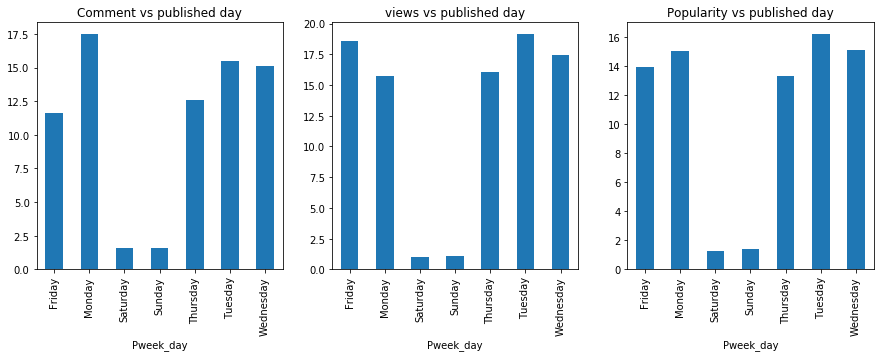

In [166]:
# Plot bar graph for publication_day vs comments, views, popularity,
#funny_factor,loughter,funny_coutnt repsectively
fig  = plt.figure()
#fig.subplots_adjust(hspace=.5)
plt.subplot(2,3,1)
x1 =df_corr.groupby(['Pweek_day'])['comments'].sum().plot(kind= 'bar',figsize=(15,10),title="Comment vs published day",sharex = True)
plt.subplot(2,3,2)
x2 = df_corr.groupby(['Pweek_day'])['views'].sum().plot(kind = 'bar',figsize=(15,10),title="views vs published day", sharex = True)
plt.subplot(2,3,3)
x3= df_corr.groupby(['Pweek_day'])['popularity'].sum().plot(kind='bar',figsize=(15,10),title="Popularity vs published day",sharex = True)


#plt.subplots_adjust()
plt.show()
y_labels = ['comments', 'views','popularity']
i = 0
for x in [x1,x2,x3]:
    x.set_ylabel(y_labels[i])
    i+=1


### Boxplot Analysis
###### Polt a Boxplot for all the features choosen,to analyse outliers and the range of the value.Compute 1st quantile , 3rd quantile and Inter Quantile Range column wise then values less than Q1-1.5*IQR and values greater that Q3+1.5*IQR are treated as outliers. Cout the number of outliers in each column and return total number of outliers in each column.


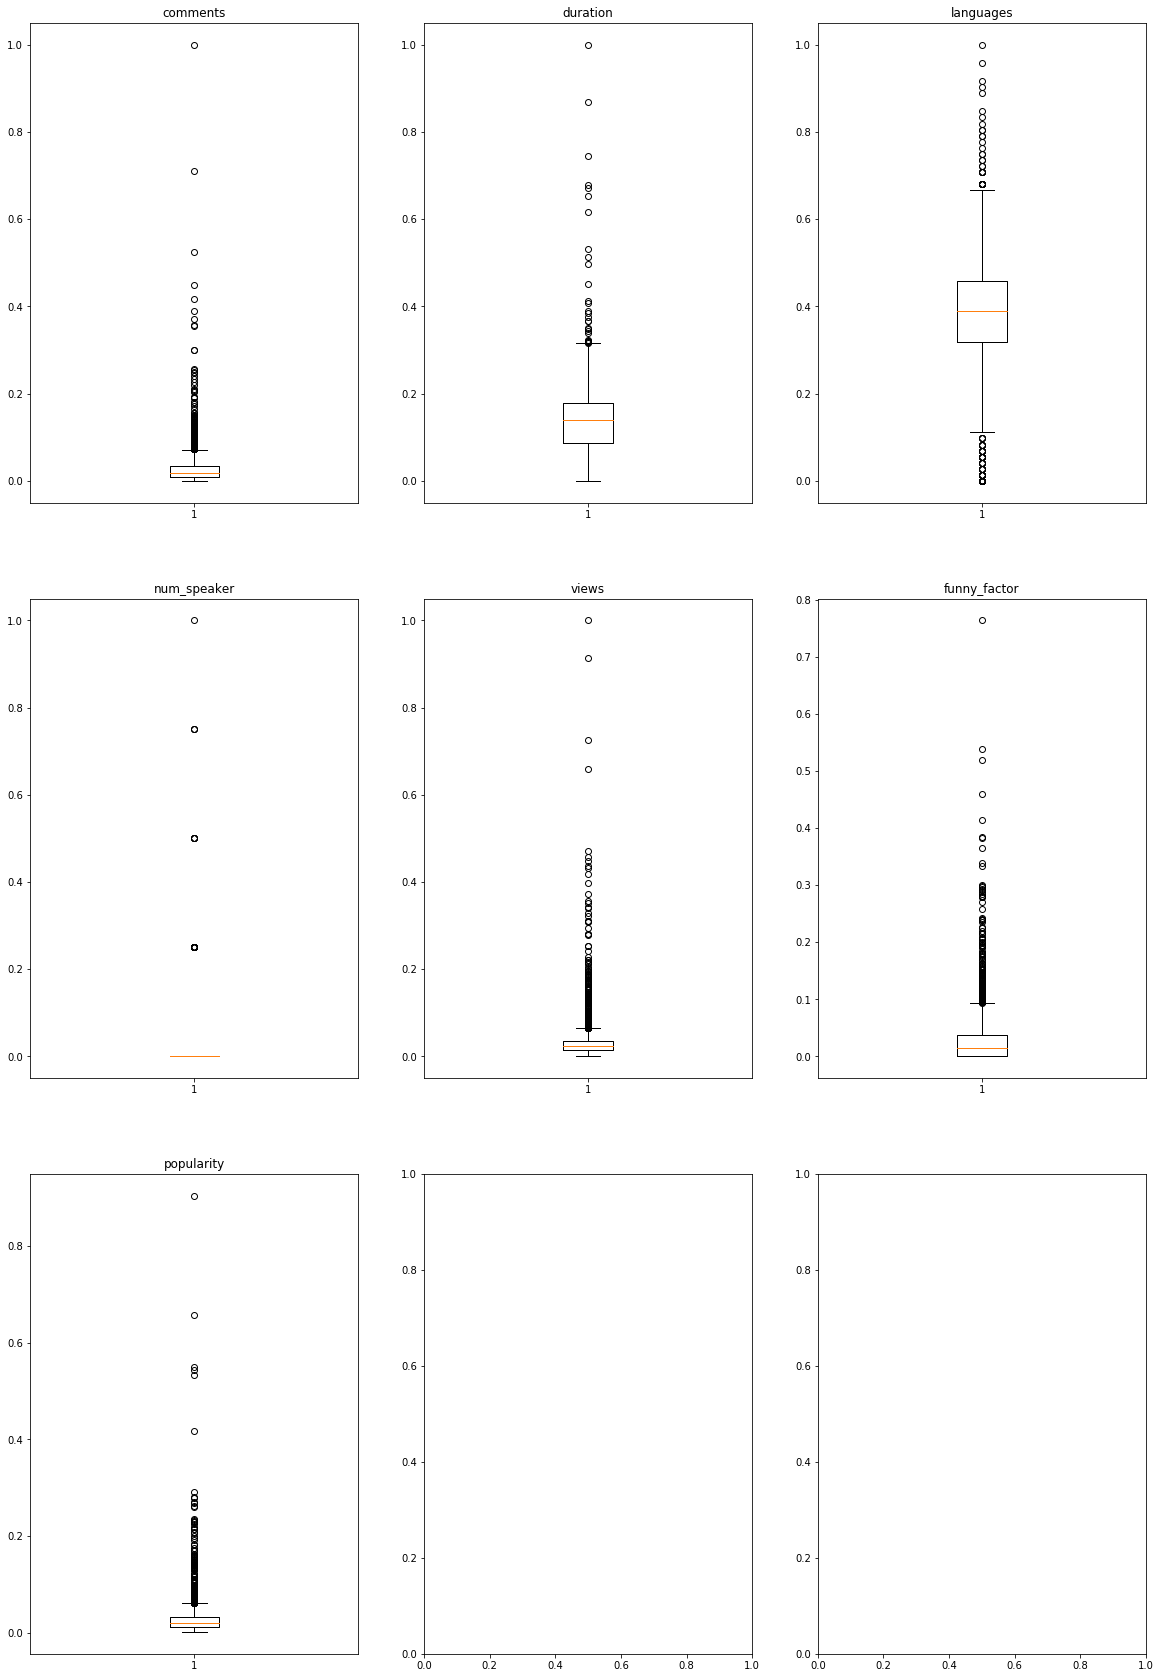

In [168]:
# Plot a boxplot for all the columns listed on colum variable 
fig, axs = plt.subplots(3, 3,figsize=(20,30))
column = ['comments','duration','languages', 'num_speaker','views','funny_factor','popularity']
plot_list = list(axs.flat)
for c,a in zip(column,plot_list):
    a.boxplot(df_corr[c])
    a.set_title(c)
    

In [169]:
# Compute first quantile(Q1), thrid Qauntile(Q3) and IQR(IRQ = Q3 -Q1) for each Column listed in variable cols
# Records with values less than Q1-1.5*IQR and values greater that Q3+1.5*IQR treat as outliers.
# Count the number of outliers for each column and return (column_name,total number of outliers)

cols = ['views','popularity','comments','funny_factor']
outdict = {}
def count_outlier():
    for i in cols:
        Q1 = df_corr[i].quantile(0.25)
        Q3 = df_corr[i].quantile(0.75)
        IQR = Q3 - Q1
        no_outlier = (df_corr[(df_corr[i] < Q1-1.5*IQR ) | (df_corr[i] > Q3+1.5*IQR)][i]).count()
        outdict[i]= no_outlier
    return ([(col_name,val)for col_name , val in outdict.items()])       
count_outlier()

[('views', 246), ('popularity', 232), ('comments', 200), ('funny_factor', 190)]

## Correlation between title as question and popularity

Let's create a column to see is the title is or not a question. Both from the correlation function and the scatterplot, we can see that there isn't correlation between the question title and the popularity of the video.

In [170]:
df['question']=0
for i in range (0,len(df)):
    if (("?") in df.loc[(i,'title')]):
        df.loc[(i,'question')] = 1
    else:
        df.loc[(i,'question')] = 0

In [171]:
df['question'].corr(df['popularity'])

0.042327481606952724

In [172]:
df['question'].value_counts()

0    2342
1     208
Name: question, dtype: int64

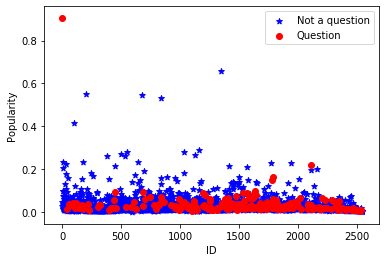

In [173]:
#add id column
df['id']=df.index
#show scatter plot

#df.plot.scatter(x = 'id', y = 'popularity')

plt.scatter(df[df['question'] == 0]['id'],df[df['question'] == 0]['popularity'], color='b', marker='*', label='Not a question')
plt.scatter(df[df['question'] == 1]['id'],df[df['question'] == 1]['popularity'], color='r',label='Question')
plt.xlabel('ID')
plt.ylabel('Popularity')
plt.legend()
plt.show()

## Analysis on the occupations of the speakers

Let's create a new dataframe containing the occupations and their count.

In [175]:
occupation_df = df.groupby('speaker_occupation').count().reset_index()[['speaker_occupation','main_speaker']]
occupation_df.columns = ['occupation', 'appearances']
occupation_df = occupation_df.sort_values('appearances', ascending=False)

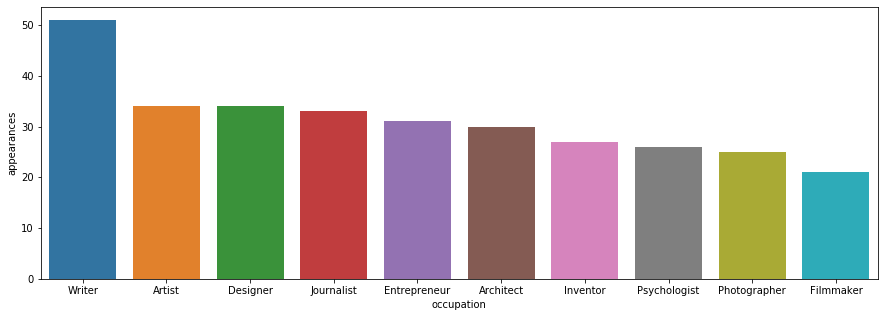

In [176]:
plt.figure(figsize=(15,5))
sns.barplot(x='occupation', y='appearances', data=occupation_df.head(10))
plt.show()

In [177]:
print('\n Sum of appearances:', sum(occupation_df['appearances']))


 Sum of appearances: 2550


The sum of the appearances indicates that there are some missing values.
Cheching the least appearances, we note that various speakers define themselves with multiple occupations.

In [178]:
zipf= occupation_df.groupby('appearances').count().reset_index()
zipf.columns = ['appearances', 'repetition']
zipf = zipf.sort_values('repetition', ascending=False)

There are a lot of unique occupations, while just a few repeat.

Let's split the occupations in different rows, mantaining the original ID

In [181]:
jobs=[]
newID=[]
lista=df['speaker_occupation']
i=1

for e in lista:
    if isinstance(e, six.string_types):
        n = len(re.findall('; |, |/| and | + ', e))
        for j in range (-1,n):
            newID+=[i]
        jobs+=re.split('; |, |/| and | + ',e.lower())
        i+=1

zippedList =  list(zip(newID,jobs))
splitted_df=pd.DataFrame(zippedList, columns =['id','occupation'])

,occupation,appearances
1296,writer,96
94,author,82
14,activist,63
76,artist,63
430,entrepreneur,57
345,designer,57
658,journalist,50
646,inventor,49
411,educator,47
67,architect,36


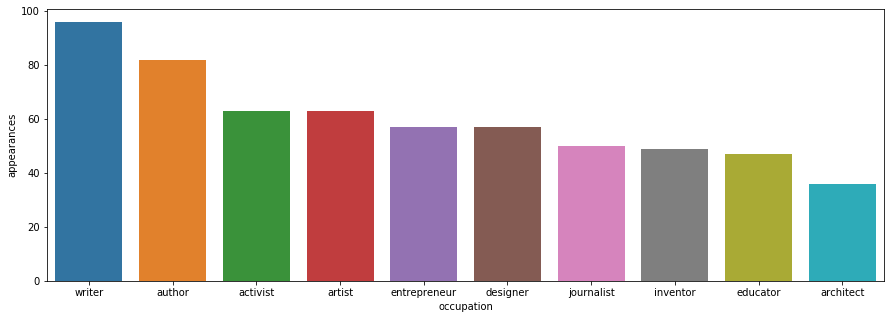

In [182]:
occupation_df2 = splitted_df.groupby(['occupation']).count().reset_index()
occupation_df2.columns = ['occupation', 'appearances']
occupation_df2 = occupation_df2.sort_values('appearances', ascending=False)
display(occupation_df2.head(10))
plt.figure(figsize=(15,5))
sns.barplot(x='occupation', y='appearances', data=occupation_df2.head(10))
plt.show()

In [183]:
zipf2= occupation_df2.groupby('appearances').count().reset_index()
zipf2.columns = ['appearances', 'repetition']
zipf2 = zipf2.sort_values('repetition', ascending=False)

The number of unique occupations has decreased, and the number of the repetition increased.